# Load data and data analysis


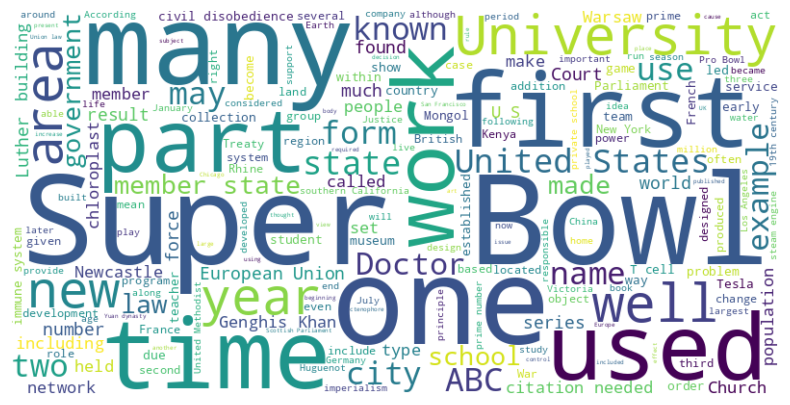

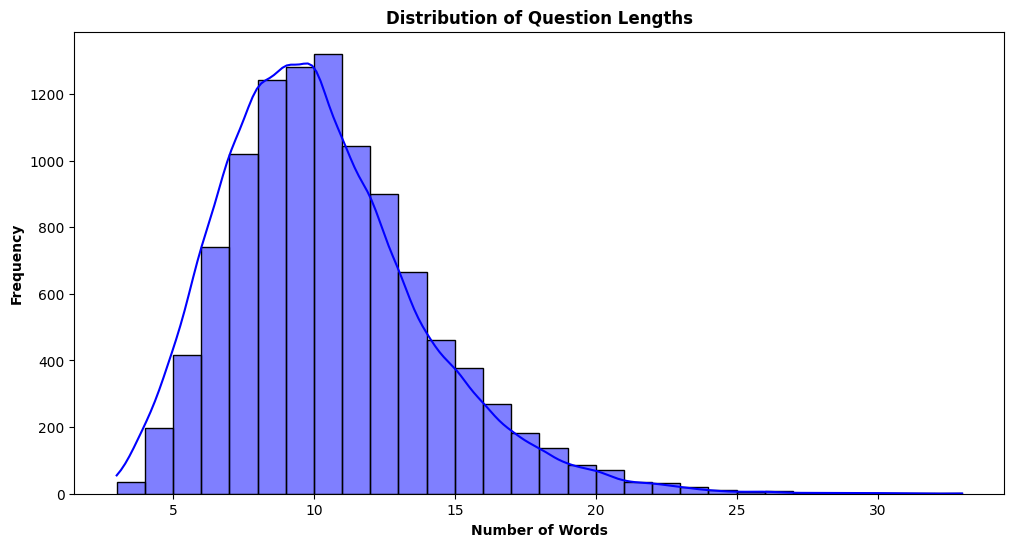

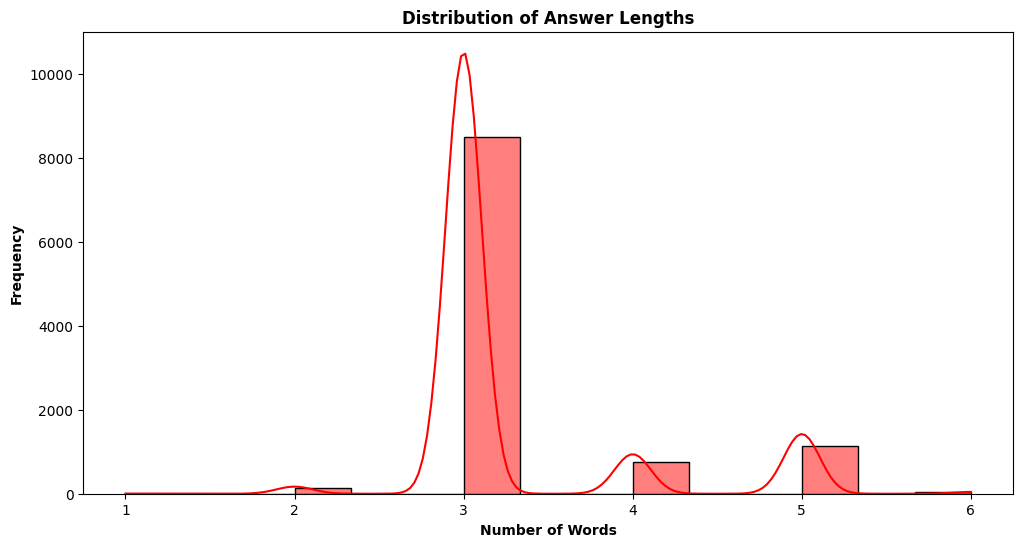

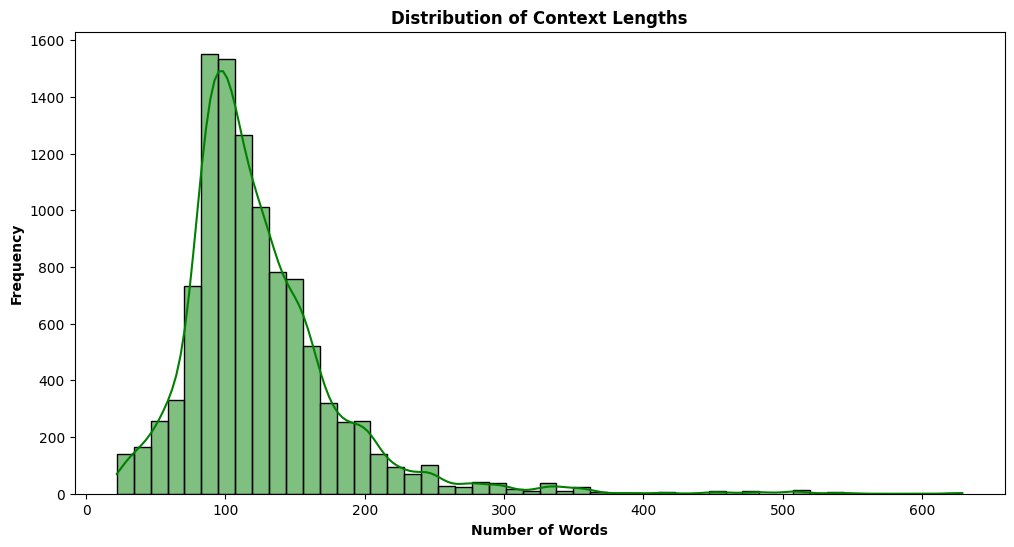

In [20]:
# https://huggingface.co/docs/datasets/v1.9.0/loading_datasets.html
from datasets import load_dataset
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt

test_set = load_dataset(
    'squad', split='validation'
)  # Get first n entries from the test set
test_contexts = test_set['context']  # List of strings
test_questions = test_set['question']  # List of strings
test_answers = [d['text'] for d in test_set['answers']]  # List of lists of answers

train_set = load_dataset(
    'squad', split='train'
)  # Get first n entries from the test set
train_contexts = train_set['context']  # List of strings
train_questions = train_set['question']  # List of strings
train_answers = [d['text'] for d in train_set['answers']]  # List of lists of answers

text_data = ' '.join(test_contexts + test_questions)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(
    text_data
)

questions_lengths = [len(question.split()) for question in test_set['question']]
contexts_lengths = [len(context.split()) for context in test_set['context']]
answer_lengths = [len(answer) for answer in test_answers]

# Word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Distribution of question lengths
plt.figure(figsize=(12, 6))
sns.histplot(questions_lengths, bins=30, kde=True, color='blue')
plt.title('Distribution of Question Lengths', fontweight='bold')
plt.xlabel('Number of Words', fontweight='bold')
plt.ylabel('Frequency', fontweight='bold')
plt.show()

# Distribution of answer lengths
plt.figure(figsize=(12, 6))
sns.histplot(answer_lengths, kde=True, color='red')
plt.title('Distribution of Answer Lengths', fontweight='bold')
plt.xlabel('Number of Words', fontweight='bold')
plt.ylabel('Frequency', fontweight='bold')
plt.show()

# Distribution of context lengths
plt.figure(figsize=(12, 6))
sns.histplot(contexts_lengths, bins=50, kde=True, color='green')
plt.title('Distribution of Context Lengths', fontweight='bold')
plt.xlabel('Number of Words', fontweight='bold')
plt.ylabel('Frequency', fontweight='bold')
plt.show()

# Passage Ranking


In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
import numpy as np


class PassageRanker:
    def __init__(self) -> None:
        self.model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

    def __get_most_similiar_sentence__(self, question, context):
        sentences = nltk.sent_tokenize(context)
        question_embedding = self.model.encode(
            [question]
        )  # Array to get the correct format
        sentences_embedding = self.model.encode(sentences)
        cosine_similiarities = cosine_similarity(
            sentences_embedding, question_embedding
        )
        return sentences[np.argmax(cosine_similiarities)]

    def get_most_relevant_passages(self, questions, contexts):
        return [
            self.__get_most_similiar_sentence__(question, context)
            for (question, context) in zip(questions, contexts)
        ]

In [ ]:
passage_ranker = PassageRanker()

In [ ]:
test_contexts_passage_ranked = passage_ranker.get_most_relevant_passages(
    test_questions, test_contexts
)

# Setup generative model (open/closed model)


In [ ]:
from transformers import AutoTokenizer, OPTForCausalLM, pipeline
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

MAX_NUM_THREADS = 10
import torch

TORCH_DEVICE = torch.device("mps")


# https://stackoverflow.com/questions/8290397/how-to-split-an-iterable-in-constant-size-chunks
def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx : min(ndx + n, l)]


class GenerativeModel:
    def __init__(self, max_answer_length) -> None:
        self.generator = pipeline('text-generation', model="facebook/opt-1.3b")
        self.model = OPTForCausalLM.from_pretrained("facebook/opt-1.3b")
        self.model.to(TORCH_DEVICE)
        self.tokenizer = AutoTokenizer.from_pretrained("facebook/opt-1.3b")
        self.tokenizer.padding_side = (
            "left"  # So that the text will continue as without padding
        )
        self.max_answer_length = max_answer_length

    def get_open_model_answer(self, question, context, use_pipeline=False):
        prompt = f"CONTEXT:\n{context}\nQUESTION:\n{question}"
        # Generate answer
        answer = self._generate_answer(prompt, use_pipeline)
        # Remove prompt from generated text
        answer = answer.removeprefix(prompt)
        return answer

    def get_closed_model_answer(self, question, use_pipeline=False):
        prompt = question
        # Generate answer
        answer = self._generate_answer(prompt, use_pipeline)
        # Remove prompt from generated text
        answer = answer.removeprefix(prompt)
        return answer

    def get_open_batch_answers(self, questions, contexts, use_pipeline=False):
        assert len(questions) == len(
            contexts
        ), "questions and contexts should have the same length"
        prompts = [
            f"CONTEXT:\n{contexts[i]}\nQUESTION:\n{questions[i]}"
            for i in range(len(questions))
        ]
        # Generate answers
        answers = self._generate_batch_answers(prompts, use_pipeline)
        # Remove prompts from generated text
        answers = [answers[i].removeprefix(prompts[i]) for i in range(len(prompts))]
        return answers

    # https://github.com/huggingface/transformers/issues/10704
    def get_closed_batch_answers(self, questions, use_pipeline=False):
        prompts = questions
        # Generate answers
        answers = self._generate_batch_answers(prompts, use_pipeline)
        # Remove prompts from generated text
        answers = [answers[i].removeprefix(prompts[i]) for i in range(len(prompts))]
        return answers

    def _generate_answer(self, prompt, use_pipeline):
        if use_pipeline:
            answer = self.generator(prompt, max_new_tokens=self.max_answer_length)[0][
                'generated_text'
            ]
        else:
            inputs = self.tokenizer(prompt, return_tensors="pt").to(TORCH_DEVICE)
            generate_ids = self.model.generate(
                inputs.input_ids, max_new_tokens=self.max_answer_length
            )
            answer = self.tokenizer.batch_decode(
                generate_ids,
                skip_special_tokens=True,
                clean_up_tokenization_spaces=False,
            )[0]
        return answer

    def _generate_batch_answers(self, prompts, use_pipeline):
        if use_pipeline:
            answers = []
            with ThreadPoolExecutor(max_workers=MAX_NUM_THREADS) as executor:
                results = list(
                    tqdm(
                        executor.map(self.__generate_answer_multithread__, prompts),
                        total=len(prompts),
                    )
                )
            answers.extend(results)
        else:
            batch_size = 64
            answers = []
            prompts_batches = batch(prompts, batch_size)
            with open("open-answers2.txt", "a") as file:
                start_i = 0
                for prompts_batch in tqdm(list(prompts_batches)):
                    batch_answers = self.__generate_answer_multithread_no_pipe__(
                        prompts_batch
                    )
                    answers.extend(batch_answers)
                    file.writelines(
                        [
                            str(index + start_i) + "; " + answer + "\n"
                            for index, answer in enumerate(batch_answers)
                        ]
                    )
                    start_i += len(batch_answers)
        return answers

    def __generate_answer_multithread_no_pipe__(self, prompts_batch):
        inputs = self.tokenizer(prompts_batch, return_tensors="pt", padding=True).to(
            TORCH_DEVICE
        )  # Padding, so that all prompts have same length for computing it as a batch
        generate_ids = self.model.generate(
            inputs.input_ids, max_new_tokens=self.max_answer_length
        )
        result = self.tokenizer.batch_decode(
            generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False
        )
        return result

    def __generate_answer_multithread__(self, prompt):
        # Your answer generation logic here
        return self.generator(prompt, max_new_tokens=self.max_answer_length)[0][
            'generated_text'
        ]

In [ ]:
generative_model = GenerativeModel(max_answer_length=42)

In [ ]:
# Test for single question
single_context = """Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50."""
single_question = "Which NFL team represented the AFC at Super Bowl 50?"
single_correct_answers = ['Denver Broncos', 'Denver Broncos', 'Denver Broncos']

print(
    f"Context: {single_context}\nQuestion: {single_question}\nCorrect answer: {single_correct_answers}"
)
print("Closed generative Model:")
print(generative_model.get_closed_model_answer(single_question))
print("Open generative Model:")
print(generative_model.get_open_model_answer(single_question, single_context))

Context: Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50.
Question: Which NFL team represented the AFC at Super Bowl 50?
Correct answer: ['Denver Broncos', 'Denver Broncos', 'Denver Broncos']
Closed generative Model:

The Denver Broncos were the AFC team at Super Bowl 50.


# Evaluation


In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.tokenize import word_tokenize
import numpy as np
from transformers import pipeline

nltk.download('punkt')
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

MAX_NUM_THREADS = 10

[nltk_data] Downloading package punkt to /Users/stephan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
class ExtractiveModel:
    def __init__(self) -> None:
        model_name = "deepset/roberta-base-squad2"
        self.pipeline = pipeline(
            'question-answering', model=model_name, tokenizer=model_name
        )

    def get_extractive_batch_answer(self, question, context):
        answer = self.pipeline(question=question, context=context)["answer"]
        return answer

    def get_extractive_batch_answers(self, questions, contexts):
        answers = []
        with ThreadPoolExecutor(max_workers=MAX_NUM_THREADS) as executor:
            results = list(
                tqdm(
                    executor.map(self.get_extractive_batch_answer, questions, contexts),
                    total=len(questions),
                )
            )
        answers.extend(results)
        return answers

In [ ]:
extractive_model = ExtractiveModel()

In [ ]:
# Test for single question
single_context = """Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50."""
single_question = "Which NFL team represented the AFC at Super Bowl 50?"
single_correct_answers = ['Denver Broncos', 'Denver Broncos', 'Denver Broncos']

print(
    f"Context: {single_context}\nQuestion: {single_question}\nCorrect answer: {single_correct_answers}"
)
print("Extractive Model:")
single_answer = extractive_model.get_extractive_batch_answer(
    single_question, single_context
)
print(single_answer)

Context: Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50.
Question: Which NFL team represented the AFC at Super Bowl 50?
Correct answer: ['Denver Broncos', 'Denver Broncos', 'Denver Broncos']
Extractive Model:
Denver Broncos


## Compute the answers from the different models


In [ ]:
%%time
closed_answers = generative_model.get_closed_batch_answers(test_questions)

100%|██████████| 166/166 [23:04<00:00,  8.34s/it]

CPU times: user 10min 5s, sys: 2min 39s, total: 12min 44s
Wall time: 23min 4s


In [ ]:
%%time
open_answers = generative_model.get_open_batch_answers(test_questions, test_contexts_passage_ranked)

100%|██████████| 166/166 [1:32:43<00:00, 33.52s/it]   

CPU times: user 7min 58s, sys: 15min 58s, total: 23min 56s
Wall time: 1h 32min 43s


In [ ]:
%%time
extractive_answers = extractive_model.get_extractive_batch_answers(test_questions, test_contexts)

100%|██████████| 10570/10570 [06:41<00:00, 26.34it/s]

CPU times: user 51min 42s, sys: 8min 1s, total: 59min 44s
Wall time: 6min 43s


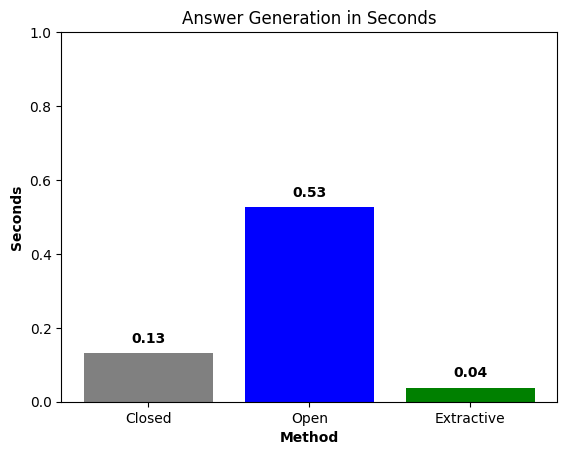

In [14]:
# Plot training values
categories = ['Closed', 'Open', 'Extractive']

training_time_in_seconds = [
    1384 / len(test_questions),  # Closed generative
    5563 / len(test_questions),  # Open generative
    403 / len(test_questions),  # Extractive
]

plt.bar(categories, training_time_in_seconds, color=['gray', 'blue', 'green'])
plt.xlabel('Method', fontweight='bold')
plt.ylabel('Seconds', fontweight='bold')
plt.title('Answer Generation in Seconds')
plt.ylim(0, 1)
for i, v in enumerate(training_time_in_seconds):
    plt.text(
        i,
        v + 0.02,
        f'{v:.2f}',
        ha='center',
        va='bottom',
        color='black',
        fontweight='bold',
    )

plt.show()

## Compute the scores for the answers


### Recall


In [ ]:
# NOTE: BLEU cannot be used, since the sentences are often very short, and BLEU uses 4-grams, so if the answer has less than 4 words, it gets a BLEU Score of 0.0


def compute_word_recall(correct_answer_, model_answer_):
    correct_answer_words = word_tokenize(correct_answer_)
    model_answer_words = set(word_tokenize(model_answer_))
    relevant_retrieved_words = np.sum(
        [(corr_word in model_answer_words) for corr_word in correct_answer_words]
    )
    all_relevant_words = len(correct_answer_words)
    return relevant_retrieved_words / all_relevant_words


def compute_word_recall_multiple_answers(
    correct_answers_single_question_, model_answer_
):
    # Return the best score, since the different answers are often synonyms and if one is taken, this is fine
    return np.max(
        [
            compute_word_recall(correct_answer, model_answer_)
            for correct_answer in correct_answers_single_question_
        ]
    )


def compute_word_recall_average(correct_answers_, model_answers_):
    all_recalls = [
        compute_word_recall_multiple_answers(correct_answer, model_answer)
        for (correct_answer, model_answer) in zip(correct_answers_, model_answers_)
    ]
    return np.mean(all_recalls)

In [ ]:
closed_recall = compute_word_recall_average(test_answers, closed_answers)
closed_recall

0.18054337354048064

In [ ]:
open_recall = compute_word_recall_average(test_answers, open_answers)
open_recall

0.5485351136381676

In [ ]:
extractive_recall = compute_word_recall_average(test_answers, extractive_answers)
extractive_recall

0.9275024108403873

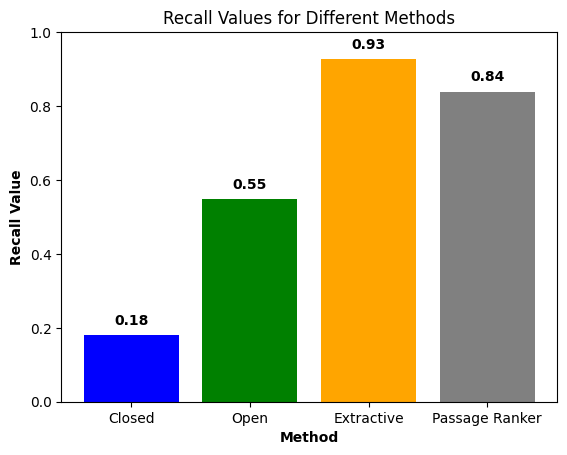

In [ ]:
# Plot recall values
categories = ['Closed', 'Open', 'Extractive', 'Passage Ranker']

values = [
    closed_recall,
    open_recall,
    extractive_recall,
    0.8391038087959786,  # Passage ranker result
]

plt.bar(categories, values, color=['blue', 'green', 'orange', 'gray'])
plt.xlabel('Method', fontweight='bold')
plt.ylabel('Recall Value', fontweight='bold')
plt.title('Recall Values for Different Methods')
plt.ylim(0, 1)
for i, v in enumerate(values):
    plt.text(
        i,
        v + 0.02,
        f'{v:.2f}',
        ha='center',
        va='bottom',
        color='black',
        fontweight='bold',
    )

plt.show()

### Precision


In [ ]:
def compute_word_precision(correct_answer_, model_answer_):
    correct_answer_words = word_tokenize(correct_answer_)
    model_answer_words = set(word_tokenize(model_answer_))
    relevant_retrieved_words = np.sum(
        [(corr_word in model_answer_words) for corr_word in correct_answer_words]
    )
    all_retrieved_words = len(model_answer_words)
    if all_retrieved_words == 0:  # Avoid division by zero
        precision = 0.0
    else:
        precision = relevant_retrieved_words / all_retrieved_words
    return precision


def compute_word_precision_multiple_answers(
    correct_answers_single_question_, model_answer_
):
    # Return the best score, since the different answers are often synonyms and if one is taken, this is fine
    return np.max(
        [
            compute_word_precision(correct_answer, model_answer_)
            for correct_answer in correct_answers_single_question_
        ]
    )


def compute_word_precision_average(correct_answers_, model_answers_):
    all_recalls = [
        compute_word_precision_multiple_answers(correct_answer, model_answer)
        for (correct_answer, model_answer) in zip(correct_answers_, model_answers_)
    ]
    return np.mean(all_recalls)

In [ ]:
closed_precision = compute_word_precision_average(test_answers, closed_answers)
closed_precision

0.04862439114355083

In [ ]:
open_precision = compute_word_precision_average(test_answers, open_answers)
open_precision

0.0883897958657373

In [ ]:
extractive_precision = compute_word_precision_average(test_answers, extractive_answers)
extractive_precision

0.9434086117813647

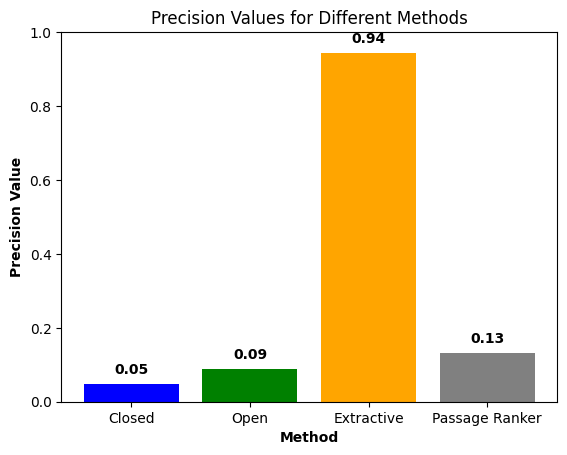

In [ ]:
# Plot precision values
categories = ['Closed', 'Open', 'Extractive', 'Passage Ranker']
values = [
    closed_precision,
    open_precision,
    extractive_precision,
    0.13244954661021957,  # Passage ranker result
]

plt.bar(categories, values, color=['blue', 'green', 'orange', 'gray'])
plt.xlabel('Method', fontweight='bold')
plt.ylabel('Precision Value', fontweight='bold')
plt.title('Precision Values for Different Methods')
plt.ylim(0, 1)
for i, v in enumerate(values):
    plt.text(
        i,
        v + 0.02,
        f'{v:.2f}',
        ha='center',
        va='bottom',
        color='black',
        fontweight='bold',
    )

plt.show()